In [1]:
import torch
import math 
import matplotlib.pyplot as plt


torch.set_grad_enabled(False)

In [2]:
def generate_disc_set(nb):
    input_ = torch.empty(nb, 2).uniform_(0,1)
    target_ = torch.empty(nb,2).long()
    
    for i in range(nb):
        if (torch.norm(input_[i]) < math.sqrt(1/(2*math.pi))):
            target_[i,0] = 0
            target_[i,1] = 1
        else : 
            target_[i,0] = 1
            target_[i,1] = 0
    return input_, target_

# Data generation 

Size of the input =  torch.Size([1000, 2])
Size of the target =  torch.Size([1000, 2])


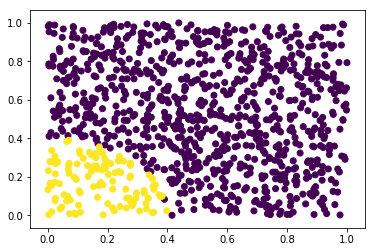

In [3]:
train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

print('Size of the input = ', train_input.size())
print('Size of the target = ', train_target.size())

plt.scatter(train_input[:,0],train_input[:,1], c = torch.argmax(train_target,dim = 1))
plt.show()

## Activation functions 

In [4]:
t = torch.empty(100,2)


## Loss

In [5]:
def LossMSE(v, t):
    return torch.sum(torch.pow(t - v, 2)).item() #1 x 2
    
def d_LossMSE(v, t):
    return (2*(v-t)) #100 x 2 

## Classes

In [6]:
class Module(object):
    
    def forward_pass(self, *_input_):
        raise NotImplementedError

    def backward_pass(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []
    
    def update(self, eta):
        return [] 
    
    def zerograd(self):
        return []    

In [7]:
x = torch.ones(100,2)
w = torch.ones(25,2)
b = torch.ones(25)

s = x @ w.t() + b
print(s.size())

a = s * (s > 0).float()
print(a.size())
print(s.tanh().size())

torch.Size([100, 25])
torch.Size([100, 25])
torch.Size([100, 25])


In [16]:
class Linear(Module):
    
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialization of paramaters (weights and biases and their gradients)
        std_init = 1e-6
        mean_init = 0
        self.w = torch.empty(out_features,in_features).normal_(mean_init,std_init)
        self.b = torch.empty(out_features).normal_(mean_init,std_init) 
        
        self.dl_dw = torch.zeros(self.w.size())
        self.dl_db = torch.zeros(self.b.size())
        
        self.cache_input_act = None
    
    def forward_pass(self, _input_):
        self.cache_input_act = _input_ # 100 x 25
        s = _input_ @ self.w.t() + self.b  #100 (batch_size) x 25
        return s

    def backward_pass(self, gradwrtoutput):
        dl_dx =  gradwrtoutput @ self.w # 100 x 25 
        self.dl_dw =  gradwrtoutput.t() @ self.cache_input_act # 2 x 25
        self.dl_db = torch.sum(gradwrtoutput, dim = 1) # We want 2 x 1
        return dl_dx
        
    def param(self):
        return [(self.w, self.dl_dw), (self.b, self.dl_db)]
     
    def update(self, eta):
        self.w -= eta * self.dl_dw
        self.b -= eta * self.dl_db
        
    def zerograd(self):
        self.dl_dw = torch.zeros(self.w.size())
        self.dl_db = torch.zeros(self.b.size())

        
class ReLU(Module):
    
    def __init__(self):
        super(ReLU, self).__init__()
        self.cache_input_linear = None
    
    def ReLU_fun(self,_input_):
        return _input_ * (_input_ > 0).float()
    
    def d_ReLU(self,_input_):
        return 1. * (_input_ > 0).float()

    def forward_pass(self, _input_):
        self.cache_input_linear = _input_
        x = self.ReLU_fun(_input_) #100 x 25
        return x

    def backward_pass(self, gradwrtoutput):
        dl_ds =  self.d_ReLU(self.cache_input_linear) * gradwrtoutput # 100 x 2 (torch.mul --> *)
        print('dl_ds size = ', dl_ds.size())
        self.cache_input_linear = None
        return dl_ds

        
class Tanh(Module):
    
    def __init__(self):
        super(Tanh, self).__init__()
        self.cache_input_linear = None
        
    def Tanh_fun(self,_input_):
        return _input_.tanh()
    
    def d_Tanh(self,_input_):
        return (1 - torch.pow(Tanh_fun(_input_), 2))

    def forward_pass(self, _input_):
        self.cache_input_linear = _input_
        x = self.Tanh_fun(_input_) #100 x 25
        return x
   
    def backward_pass(self, gradwrtoutput):
        dl_ds =  self.d_Tanh(self.cache_input_linear).t() * gradwrtoutput # 100 x 2
        self.cache_input_linear = None
        return dl_ds

In [9]:
class Sequential(Module):
    
    def __init__(self, *args):
        super(Sequential, self).__init__()
        self.modules = []
        self.forward = None
        self.backward = None
        for module in args:
            self.modules.append(module)
    
    def forward_pass(self, _input_):
        self.forward = _input_
        for module in self.modules:
            self.forward = module.forward_pass(self.forward)
        return self.forward
            
    def backward_pass(self, target):
        self.backward = d_LossMSE(self.forward, target) #100 x 2
        for module in reversed(self.modules):
            self.backward = module.backward_pass(self.backward)
    
    def zerograd(self):
        for module in self.modules:
            module.zerograd()
            
    def update(self, eta):
        for module in self.modules:
            if(len(module.param()) > 0):
                module.update(eta) # Maybe we should change eta over time 

In [18]:
def train(model, train_input, train_target, eta, mini_batch_size, epochs):
    losses = []
    for e in range(epochs):
        batch_loss = 0 
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward_pass(train_input.narrow(0,b,mini_batch_size))
            print('Output size =', output.size())
            a = train_target.narrow(0,b,mini_batch_size)
            print('Target size =', a.size())
            batch_loss += LossMSE(output, train_target.narrow(0,b,mini_batch_size))
            model.backward_pass(train_target.narrow(0,b,mini_batch_size))
            model.update(eta)
            model.zerograd()
            
        losses.append(batch_loss)
    return losses,total_loss/1000

In [20]:
eta = 0.1
mini_batch_size = 100
epochs = 3

model = Sequential(Linear(2,25), ReLU(),Linear(25,2),Tanh())

losses, errors = train(model, test_input, test_target, eta, mini_batch_size, epochs)
print('Losses',losses)
print('')
print('% Error',errors)



Output size = torch.Size([100, 2])
Target size = torch.Size([100, 2])


RuntimeError: expected type torch.FloatTensor but got torch.LongTensor